In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pgeocode as pgeo
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.spatial
import networkx as nx
from run_gcmc import run

In [2]:
%matplotlib inline

General function

In [3]:
def split_str_list(x, sep):
    """Function to split comma seperated string into array type data"""
    if type(x) == str and x != "" and x != "\\N":
        return x.split(sep)
    else:
        return None
    
def self_df_crossjoin(df):
    """Function to cross join a dataframe with itself"""
    df['tmpkey'] = 1
    res = pd.merge(df, df, on='tmpkey').drop('tmpkey', axis=1)
    df.drop('tmpkey', axis=1, inplace=True)
    return res

def bootstrap_mean_ci(data, percentile, n_sample):
    '''Function to compute the bootstrap confidence interval for the mean'''
    sample_means = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_means.append(np.nanmean(sample))
    
    return [np.round(np.percentile(sample_means, percentile), 3), \
            np.round(np.percentile(sample_means, 100-percentile), 3)]

def plot_barplot(df, sort, horizontal, xlabel, ylabel, title, fig_x, fig_y):
    "Function that makes a barplot for a specific type of dataframe"
    df['errlo']  = df['mean'] - df['95% CI mean'].apply(lambda x: x[0])

    df['errhi']  = df['95% CI mean'].apply(lambda x: x[1]) - df['mean']

    if horizontal:
        if sort:
            df.sort_values(by='mean', inplace=True, ascending=True)
        df.plot(kind='barh', y='mean', xerr=df[['errlo','errhi']].T.values, \
                          alpha=0.5, capsize=5, figsize=(fig_x, fig_y), legend=False);
    else:
        if sort:
            df.sort_values(by='mean', inplace=True, ascending=False)
        df.plot(kind='bar', y='mean', yerr=df[['errlo','errhi']].T.values, \
                          alpha=0.5, capsize=5, figsize=(fig_x, fig_y), legend=False);

    plt.xlabel(xlabel, size='large')
    plt.ylabel(ylabel, size="large")
    plt.title(title, size="large");

Function specific to the course

In [4]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    distance = scipy.spatial.distance.pdist(X, 'euclidean')
    weight = np.exp(-distance**2/(2*sigma**2))
    adjacency = scipy.spatial.distance.squareform(np.where(weight > epsilon, weight, 0))
    return adjacency

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    degrees = np.asarray([sum(adjacency[i,:]) for i in range(adjacency.shape[0])])
    laplacian = np.diag(degrees) - adjacency

    if normalize:
        for i in range(adjacency.shape[0]):
            for j in range(adjacency.shape[1]):
                if (degrees[i] == 0) or (degrees[j] == 0): #To avoid division by 0
                    laplacian[i][j] = 0
                else:
                    laplacian[i][j] = laplacian[i][j] / np.sqrt(degrees[i]*degrees[j])
        
    return laplacian

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    return np.linalg.eigh(laplacian)

def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return (lamb < threshold).sum()

# Data Loading

In [5]:
PATH = 'ml-100k/'

In [6]:
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(PATH + 'u.user', sep='|', names=u_cols, encoding='latin-1') 

In [7]:
r_cols = ['user_id', 'movie_id', 'rating', 'date']
ratings = pd.read_csv(PATH + 'u.data', sep='\t', names=r_cols, encoding='latin-1')

The is the u.item file from movielens with the imdb id obtained from scraping

In [9]:
movies = pd.read_pickle('ml-100k/movies_scraped.pkl')
movies.rename({'best_id': 'imdb_id'}, axis=1, inplace=True)

In [10]:
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [11]:
ratings.head()

,user_id,movie_id,rating,date
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies.head()

,movie_id,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdb_id
0,1,Toy Story (1995),1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,tt0114709
1,2,GoldenEye (1995),1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,tt0113189
2,3,Four Rooms (1995),1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,tt0113101
3,4,Get Shorty (1995),1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,tt0113161
4,5,Copycat (1995),1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,tt0112722


# Adding more information with files from imdb and pgeocode

## Users

In [13]:
def get_us_state(zip_code):
    infos = geo.query_postal_code(zip_code)
    return infos.state_name

In [14]:
users['zip_code'].isnull().sum()

0

In [15]:
geo = pgeo.Nominatim('us')
users['state'] = users['zip_code'].apply(get_us_state)

Dataset taken from https://www.psc.isr.umich.edu/dis/census/Features/tract2zip/ median income from 2006-2010 for each zip code

In [16]:
z_cols = ['zip_code', 'median', 'mean', 'pop']
zip_income = pd.read_excel(PATH + 'zip_income.xlsx', names=z_cols)
#The zip_code 02245 is written as 2245 in the excel file, we correct it
zip_income['zip_code'] = zip_income['zip_code'].apply(lambda x: '0' + str(x) if len(str(x)) == 4 else x)

In [17]:
#We change the zip codes to string because they have a different type in zip_income and users
users = pd.merge(users.assign(zip_code=users.zip_code.astype(str)), 
         zip_income.assign(zip_code=zip_income.zip_code.astype(str)), 
         how='left', on='zip_code')

We replace the user with nan incomes with the median income of their state if we know it, otherwise we replace it by the median over the whole dataset

In [18]:
users['median'].fillna(users.groupby(['state'])['median'].transform('median'), inplace=True)
users['median'].fillna(np.nanmedian(users['median']), inplace=True)

## Movies

### Runtime

imdb file containing the runtime in minutes for most of the movies

In [19]:
movies_runtime = pd.read_csv('ml-100k/title.basics.tsv.gz', sep='\t', na_values= '\\N')\
                            [['tconst', 'runtimeMinutes']]

In [20]:
movies = movies.merge(movies_runtime, left_on='imdb_id', right_on='tconst', how='left').drop('tconst', axis=1)

### Crew

imdb file containing the directors and writers for each movie

In [21]:
movies_crew = pd.read_csv('ml-100k/title.crew.tsv.gz', sep='\t', na_values= '\\N')

In [22]:
movies = movies.merge(movies_crew, left_on='imdb_id', right_on='tconst', how='left').drop('tconst', axis=1)

In [23]:
movies['directors'] = movies['directors'].apply(lambda x: split_str_list(x, ','))
movies['writers'] = movies['writers'].apply(lambda x: split_str_list(x, ','))
movies = movies.replace({'directors': None, 'writers': None}, np.nan)

In [24]:
directors = list(movies[~movies['directors'].isnull()]['directors'].values)
#Get a flat list form a list of list
directors = [item for sublist in directors for item in sublist]

In [25]:
directors = set(directors)
print('Number of unique directors: ' + str(len(directors)))

Number of unique directors: 1204


In [26]:
writers = list(movies[~movies['writers'].isnull()]['writers'].values)
#Get a flat list from a list of list
writers = [item for sublist in writers for item in sublist]

In [27]:
directors = set(directors)
print('Number of unique writers: ' + str(len(writers)))

Number of unique writers: 4078


This is probably too much to be used as a one-hot encoder for the features

### Ratings

File with the average rating on imdb for each movie

In [28]:
movies_rating = pd.read_csv('ml-100k/title.ratings.tsv.gz', sep='\t', na_values= '\\N')

For some reason the file contains duplicates

In [29]:
movies_rating = movies_rating.drop_duplicates()

In [30]:
movies = movies.merge(movies_rating, left_on='imdb_id', right_on='tconst', how='left').drop('tconst', axis=1)

# Exploratory data analysis

## Users

### Gender

We get a list of all the ratings for all the users

In [31]:
users_ratings = ratings.groupby('user_id')['rating'].agg(lambda x: list(x))
users = users.merge(users_ratings, on='user_id')

In [32]:
gender_rating = users.groupby('gender')['rating'].agg(['count', lambda x: list(x)])
gender_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
gender_rating['ratings'] = gender_rating['ratings'].apply(lambda x: [item for sublist in x for item in sublist])

gender_rating['mean'] = gender_rating['ratings'].apply(np.mean)
gender_rating['95% CI mean'] = gender_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
gender_rating.drop('ratings', axis=1, inplace=True)

In [36]:
gender_rating

,count,mean,95% CI mean
gender,,,
F,273,3.531507,"[3.52, 3.542]"
M,670,3.529289,"[3.523, 3.536]"


Almost no difference in the average of rating for the gender of the users

### Age

In [33]:
users['mean_rating'] = users['rating'].apply(np.mean)

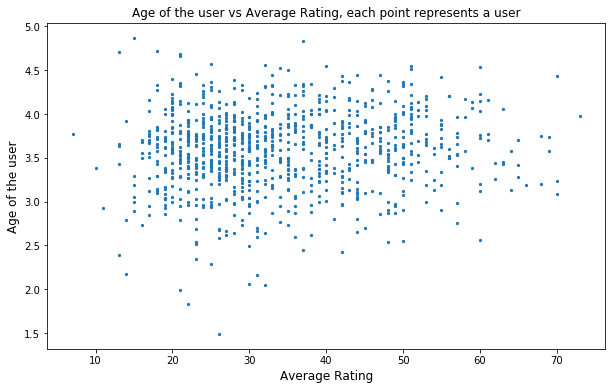

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(users['age'], users['mean_rating'], s=5);
plt.title('Age of the user vs Average Rating, each point represents a user')
plt.xlabel('Average Rating', size='large')
plt.ylabel('Age of the user', size='large');

In [35]:
intervals = np.arange(15, 70, 5)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 75)
age_rating = users.groupby(pd.cut(users['age'], intervals))['rating'].agg(['count', lambda x: list(x)])
                                       
age_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
age_rating['ratings'] = age_rating['ratings'].apply(lambda x: [item for sublist in x for item in sublist])

age_rating['mean'] = age_rating['ratings'].apply(np.mean)
age_rating['95% CI mean'] = age_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
age_rating.drop('ratings', axis=1, inplace=True)

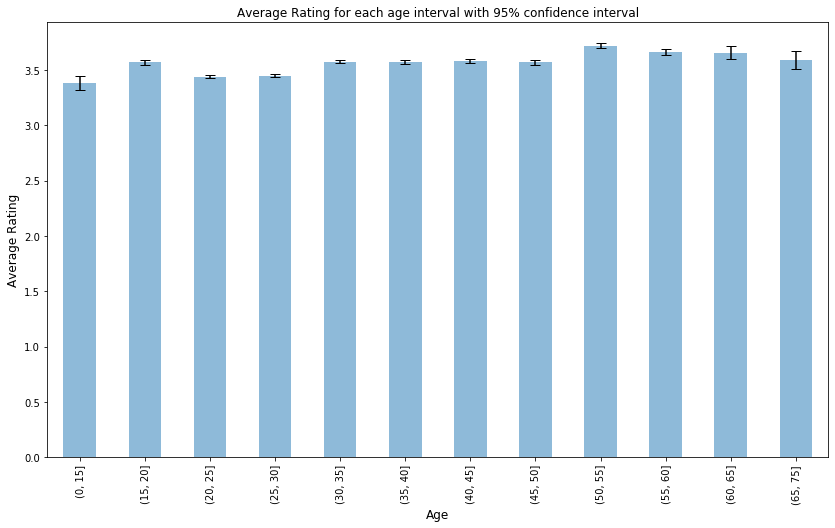

In [36]:
plot_barplot(age_rating, False, False, "Age", "Average Rating", \
             "Average Rating for each age interval with 95% confidence interval", 14,8)

### Median revenue

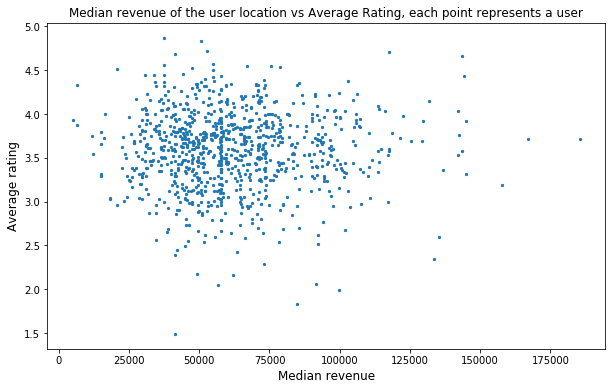

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(users['median'], users['mean_rating'], s=5);
plt.title('Median revenue of the user location vs Average Rating, each point represents a user')
plt.xlabel('Median revenue', size='large')
plt.ylabel('Average rating', size='large');

In [39]:
intervals = np.arange(30000, 110000, 10000)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 200000)
revenue_rating = users.groupby(pd.cut(users['median'], intervals))['rating'].agg(['count', lambda x: list(x)])

revenue_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
revenue_rating['ratings'] = revenue_rating['ratings'].apply(lambda x: [item for sublist in x for item in sublist])

revenue_rating['mean'] = revenue_rating['ratings'].apply(np.mean)
revenue_rating['95% CI mean'] = revenue_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
revenue_rating.drop('ratings', axis=1, inplace=True)

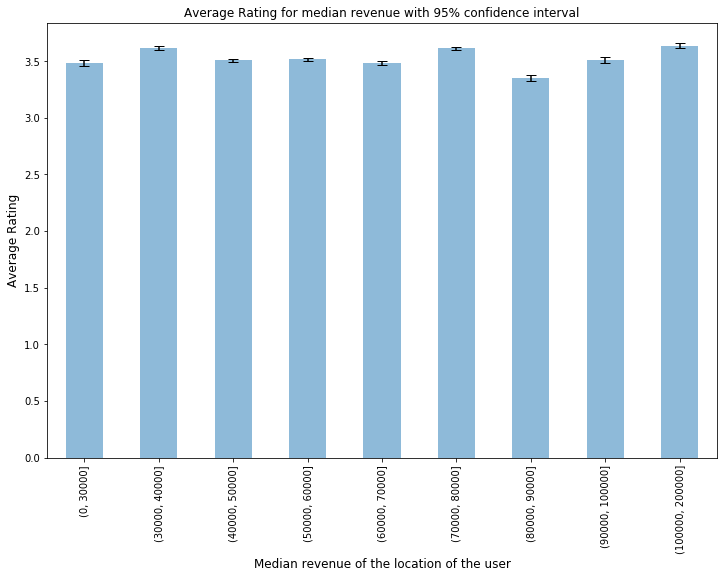

In [40]:
plot_barplot(revenue_rating, False, False, "Median revenue of the location of the user", "Average Rating", \
             "Average Rating for median revenue with 95% confidence interval", 12,8)

### US state

In [41]:
states_rating = users.groupby('state')['rating'].agg(['count', lambda x: list(x)])
states_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
states_rating['ratings'] = states_rating['ratings'].apply(lambda x: [item for sublist in x for item in sublist])

states_rating['mean'] = states_rating['ratings'].apply(np.mean)
states_rating['95% CI mean'] = states_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
states_rating.drop('ratings', axis=1, inplace=True)

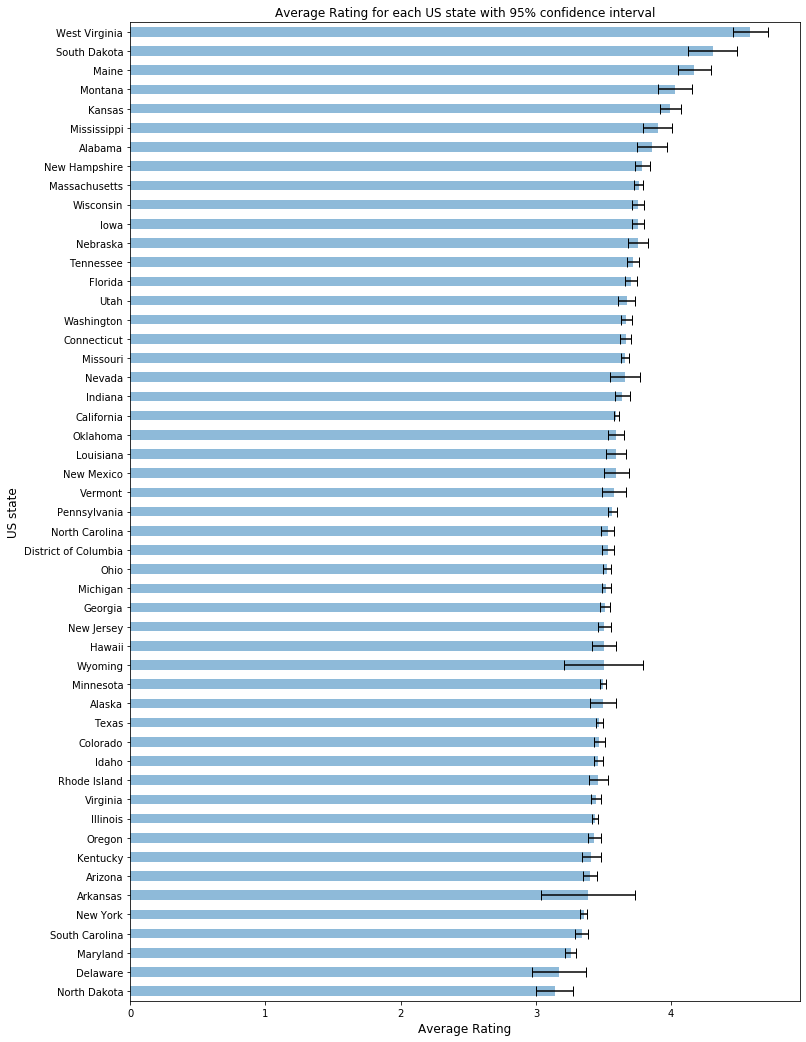

In [42]:
plot_barplot(states_rating, True, True, "Average Rating", "US state", \
             "Average Rating for each US state with 95% confidence interval", 12,18)

### Occupation

In [43]:
occupations_rating = users.groupby('occupation')['rating'].agg(['count', lambda x: list(x)])
occupations_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
occupations_rating['ratings'] = occupations_rating['ratings']\
                               .apply(lambda x: [item for sublist in x for item in sublist])

occupations_rating['mean'] = occupations_rating['ratings'].apply(np.mean)
occupations_rating['95% CI mean'] = occupations_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
occupations_rating.drop('ratings', axis=1, inplace=True)

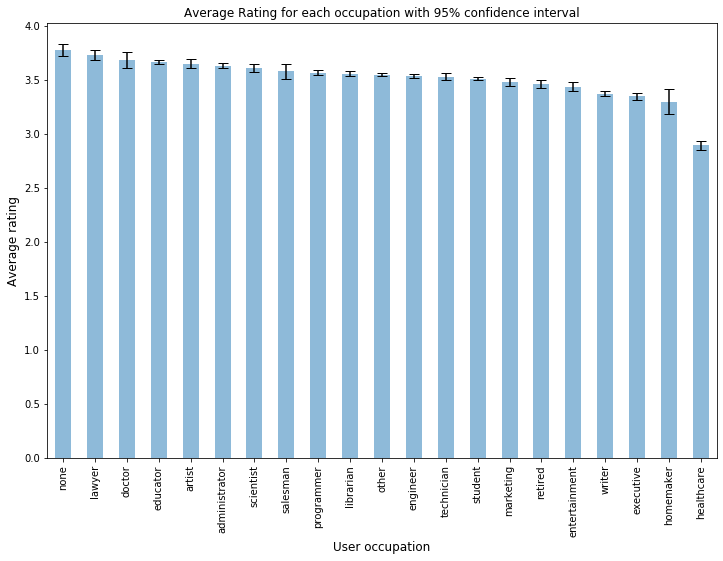

In [44]:
plot_barplot(occupations_rating, True, False, "User occupation", "Average rating", \
             "Average Rating for each occupation with 95% confidence interval", 12,8)

## Movies

### Genre

In [45]:
movies_ratings = ratings.groupby('movie_id')['rating'].agg(lambda x: list(x))
movies = movies.merge(movies_ratings, on='movie_id')

In [46]:
movies_genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',\
                 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',\
                 'Western']

genres_dict = {}

for genre in movies_genres:
    list_list_ratings = movies[movies[genre] == 1]['rating'].apply(lambda x: list(x))
    list_ratings = [item for sublist in list_list_ratings for item in sublist]
    temp_dict = {}
    temp_dict['mean'] = np.mean(list_ratings)
    temp_dict['95% CI mean'] = bootstrap_mean_ci(list_ratings, 5, 1000)
    genres_dict[genre] = temp_dict
    
genre_rating = pd.DataFrame(genres_dict).transpose()

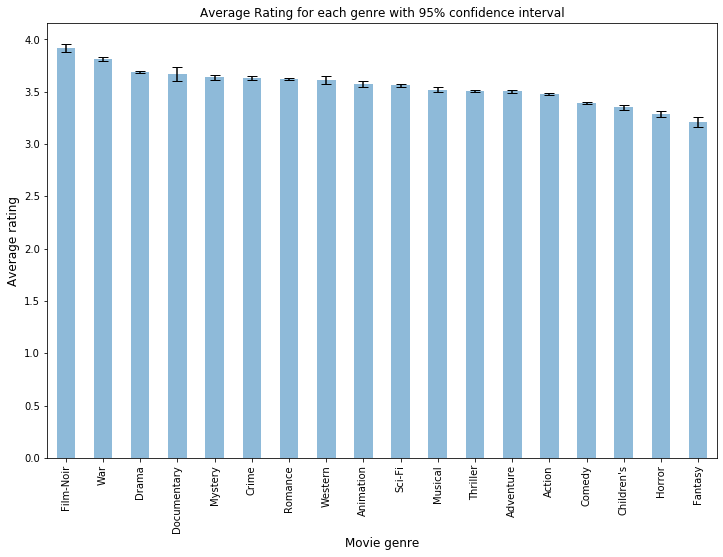

In [47]:
plot_barplot(genre_rating, True, False, "Movie genre", "Average rating", \
             "Average Rating for each genre with 95% confidence interval", 12,8)

### Runtime

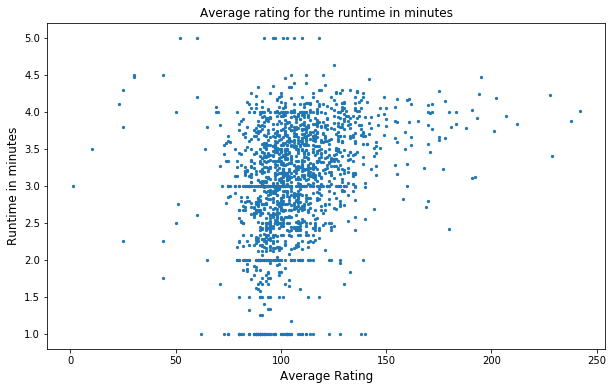

In [48]:
movies['mean_rating'] = movies['rating'].apply(np.mean)
plt.figure(figsize=(10,6))
plt.scatter(movies['runtimeMinutes'], movies['mean_rating'], s=5);
plt.title('Average rating for the runtime in minutes')
plt.xlabel('Average Rating', size='large')
plt.ylabel('Runtime in minutes', size='large');

In [49]:
intervals = np.arange(80, 160, 10)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 250)
runtime_rating = movies.groupby(pd.cut(movies['runtimeMinutes'], intervals))['rating']\
                                  .agg(['count', lambda x: list(x)])

runtime_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
runtime_rating['ratings'] = runtime_rating['ratings'].apply(lambda x: [item for sublist in x for item in sublist])

runtime_rating['mean'] = runtime_rating['ratings'].apply(np.mean)
runtime_rating['95% CI mean'] = runtime_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
runtime_rating.drop('ratings', axis=1, inplace=True)

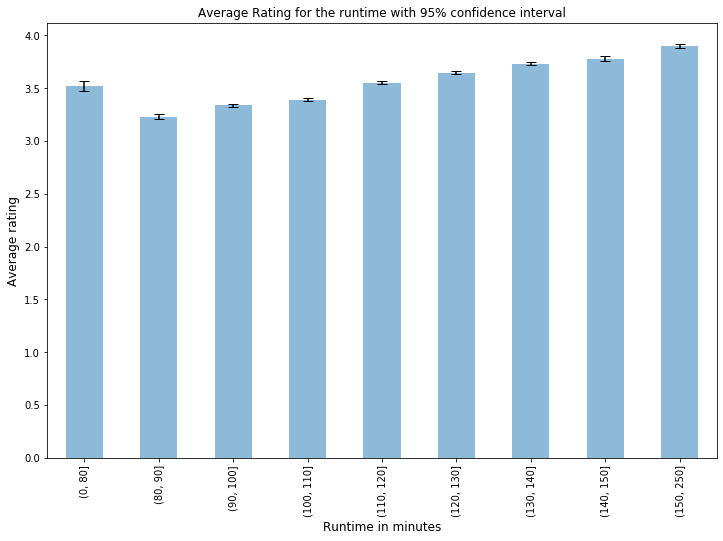

In [50]:
plot_barplot(runtime_rating, False, False, "Runtime in minutes", "Average rating", \
             "Average Rating for the runtime with 95% confidence interval", 12,8)

### imdb average rating

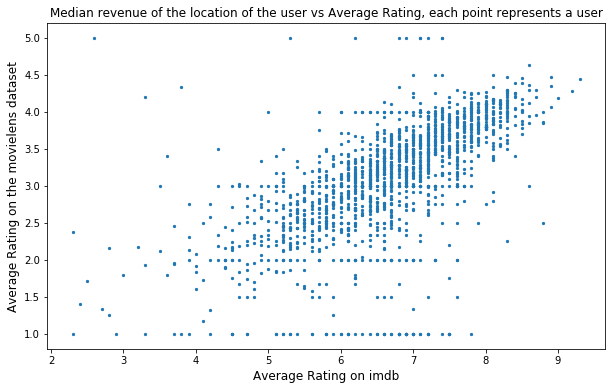

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(movies['averageRating'], movies['mean_rating'], s=5);
plt.title('Median revenue of the location of the user vs Average Rating, each point represents a user')
plt.xlabel('Average Rating on imdb', size='large')
plt.ylabel('Average Rating on the movielens dataset', size='large');

In [52]:
intervals = np.arange(4, 9, 1)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 10)
rating_rating = movies.groupby(pd.cut(movies['averageRating'], intervals))['rating']\
                                  .agg(['count', lambda x: list(x)])

rating_rating.rename(columns={'<lambda_0>': 'ratings'}, inplace=True)
rating_rating['ratings'] = rating_rating['ratings'].apply(lambda x: [item for sublist in x for item in sublist])

rating_rating['mean'] = rating_rating['ratings'].apply(np.mean)
rating_rating['95% CI mean'] = rating_rating['ratings'].apply(lambda x: bootstrap_mean_ci(x, 5, 1000))
rating_rating.drop('ratings', axis=1, inplace=True)

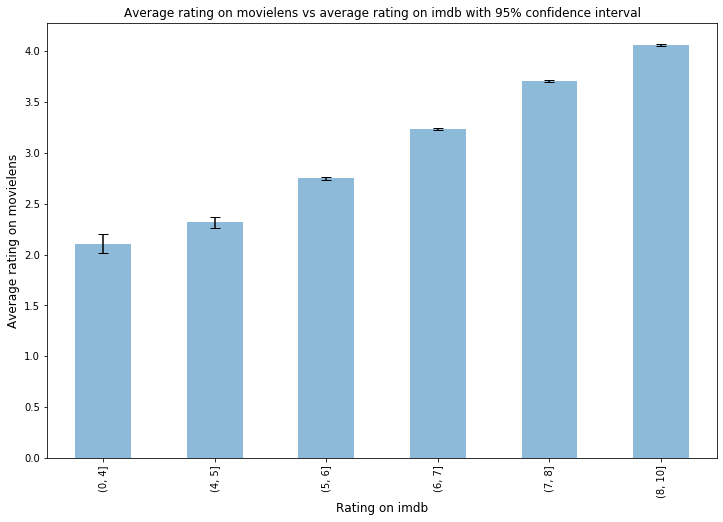

In [53]:
plot_barplot(rating_rating, False, False, "Rating on imdb", "Average rating on movielens", \
             "Average rating on movielens vs average rating on imdb with 95% confidence interval", 12,8)

Without any surprise the average rating on imdb correlates quite well with the average rating on movielens

# Building the feature matrices

The user feature matrix contains information about the age, the gender, the US state where the user lives and the median income per year of its location given by the zip code. We will use the features for the model and to build an epsilon-similarity graph

We drop one of the occupation to avoid dependance

In [54]:
users['std_rating'] = users['rating'].apply(np.std)
users.replace({'occupation' : {'other': np.nan}}, inplace=True)

In [55]:
users.replace({'gender' : {'M': 0, 'F': 1}}, inplace=True)
users_features = users['age'] / max(users['age'])
users_features = pd.concat([users_features, users['gender']], axis=1)
users_features = pd.concat([users_features, pd.get_dummies(users['occupation'])], axis=1)

users_features = pd.concat([users_features, users['median'] / max(users['median'])], axis=1)
users_features = pd.concat([users_features, pd.get_dummies(users['state'])], axis=1)

We compute how old the movie was when the dataset was released

In [56]:
movies['std_rating'] = movies['rating'].apply(np.std)

In [57]:
movies['age'] = movies['release_date'].apply(lambda x: 1998.0 - float(x))
movies['age'].fillna(np.nanmedian(movies['age']), inplace=True)
movies['runtimeMinutes'].fillna(np.nanmedian(movies['age']), inplace=True)
movies['averageRating'].fillna(np.nanmedian(movies['age']), inplace=True)
movies['numVotes'].fillna(np.nanmedian(movies['age']), inplace=True)

movies_features = movies['age'] / max(movies['age'])
movies_features = pd.concat([movies_features, movies['runtimeMinutes'] / max(movies['runtimeMinutes'])], axis=1)
movies_features = pd.concat([movies_features, movies['averageRating'] / max(movies['averageRating'])], axis=1)
movies_features = pd.concat([movies_features, movies['numVotes'] / max(movies['numVotes'])], axis=1)
movies_features = pd.concat([movies_features, movies[movies_genres]], axis=1)

# Graph Visualization

## Feature graph

### Users

In [59]:
distances_users = scipy.spatial.distance.pdist(users_features.values, metric='euclidean')
print('The mean euclidean distance between each user in the feature space is {:.4f}'.\
      format(np.mean(distances_users)))

The mean euclidean distance between each user in the feature space is 1.9699


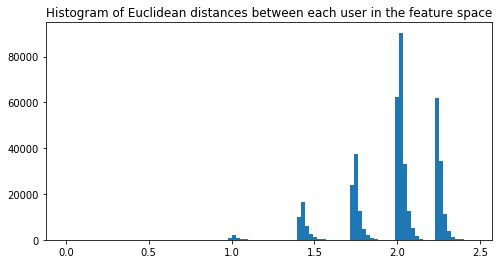

In [60]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between each user in the feature space")
plt.hist(distances_users, bins=100);

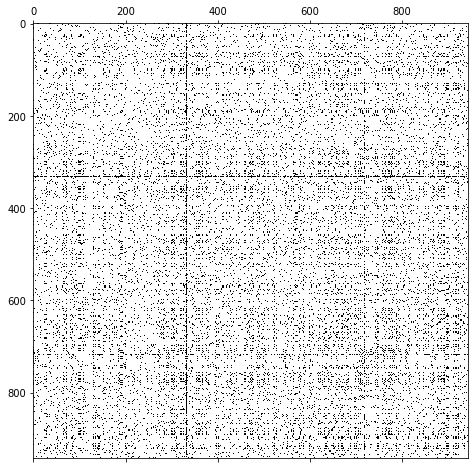

In [61]:
adjacency_users = epsilon_similarity_graph(users_features.values, sigma=0.4*np.mean(distances_users), epsilon=0.15)
plt.figure(figsize=(8,8))
plt.spy(adjacency_users)
plt.show()

In [62]:
laplacian_users = compute_laplacian(adjacency_users, normalize=True)
lamb_users, U_users = spectral_decomposition(laplacian_users)

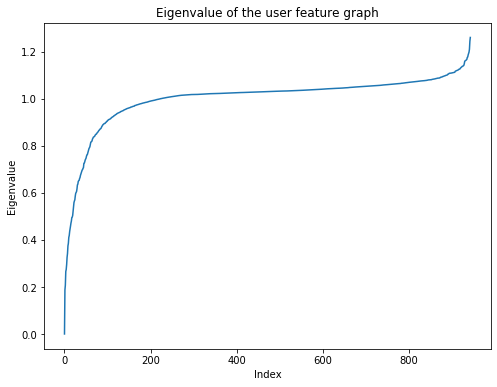

In [63]:
plt.figure(figsize=(8,6))
plt.plot(lamb_users)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue of the user feature graph');

In [64]:
adjacency_users = np.where(adjacency_users > 0, 1, 0)

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


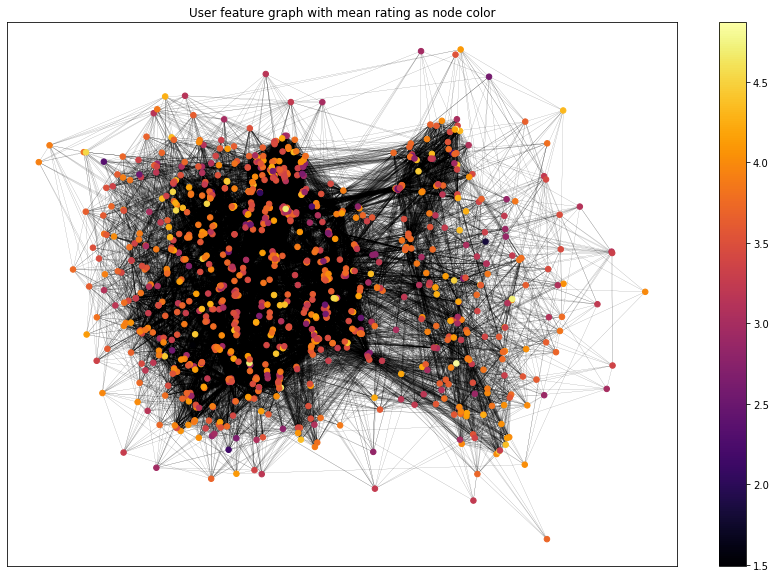

In [65]:
G_user = nx.from_numpy_matrix(adjacency_users)
coords = nx.spring_layout(G_user)  
fig = plt.figure(figsize=(15, 10))
labels = users['mean_rating'].iloc[np.sort(nx.nodes(G_user))]
im = nx.draw_networkx_nodes(G_user, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(users['mean_rating']), vmax=max(users['mean_rating']))
nx.draw_networkx_edges(G_user, coords, alpha=1.0, width=0.1)
plt.title('User feature graph with mean rating as node color', size='large')
plt.colorbar(im);

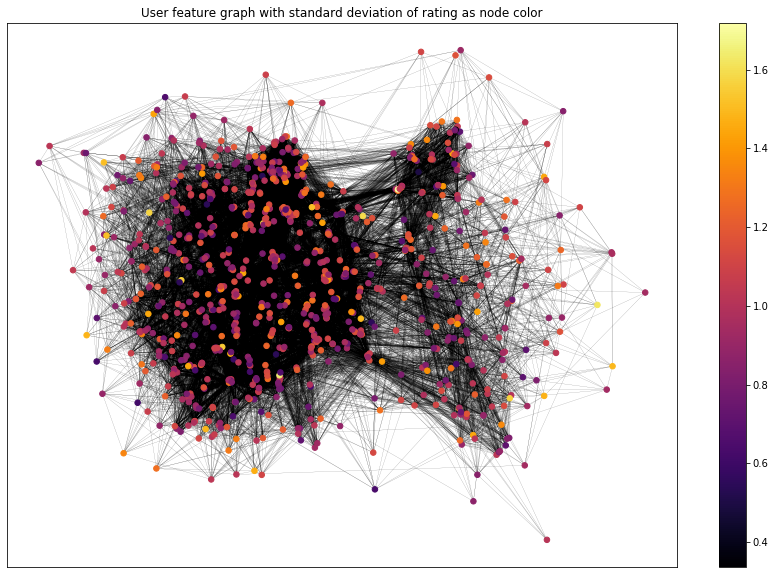

In [66]:
fig = plt.figure(figsize=(15, 10))
labels = users['std_rating'].iloc[np.sort(nx.nodes(G_user))]
im = nx.draw_networkx_nodes(G_user, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(users['std_rating']), vmax=max(users['std_rating']))
nx.draw_networkx_edges(G_user, coords, alpha=1.0, width=0.1)
plt.title('User feature graph with standard deviation of rating as node color', size='large')
plt.colorbar(im);

In [67]:
degrees_users = np.sum(adjacency_users, axis = 0)
print('Number of nodes in the feature graph: {}, Number of edges in the feature features: {}'. \
      format(G_user.number_of_nodes(), G_user.number_of_edges()))
print('Average degree of the feature graph: {:.4f}, Standard deviation of the degree in the feature graph: {:.4f}'. \
      format(np.mean(degrees_users), np.std(degrees_users)))
print('Number of connected components in the feature graph: {}, Average clustering coefficient: {}'.\
      format(nx.number_connected_components(G_user), nx.average_clustering(G_user)))
print('Diameter of the graph: {}'.\
      format(nx.diameter(G_user)))

Number of nodes in the feature graph: 943, Number of edges in the feature features: 42400
Average degree of the feature graph: 89.9258, Standard deviation of the degree in the feature graph: 62.3794
Number of connected components in the feature graph: 1, Average clustering coefficient: 0.6732103197518656
Diameter of the graph: 3


#### movies

In [68]:
distances_movies = scipy.spatial.distance.pdist(movies_features.values, metric='euclidean')
print('The mean euclidean distance between each movie in the feature space is {:.4f}'.\
      format(np.mean(distances_movies)))

The mean euclidean distance between each movie in the feature space is 1.5950


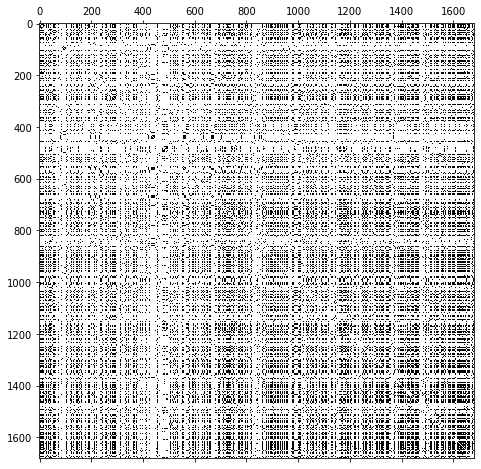

In [69]:
adjacency_movies = epsilon_similarity_graph(movies_features.values, sigma=0.4*np.mean(distances_movies), \
                                            epsilon=0.15)
plt.figure(figsize=(8,8))
plt.spy(adjacency_movies)
plt.show()

In [70]:
adjacency_movies = np.where(adjacency_movies > 0, 1, 0)

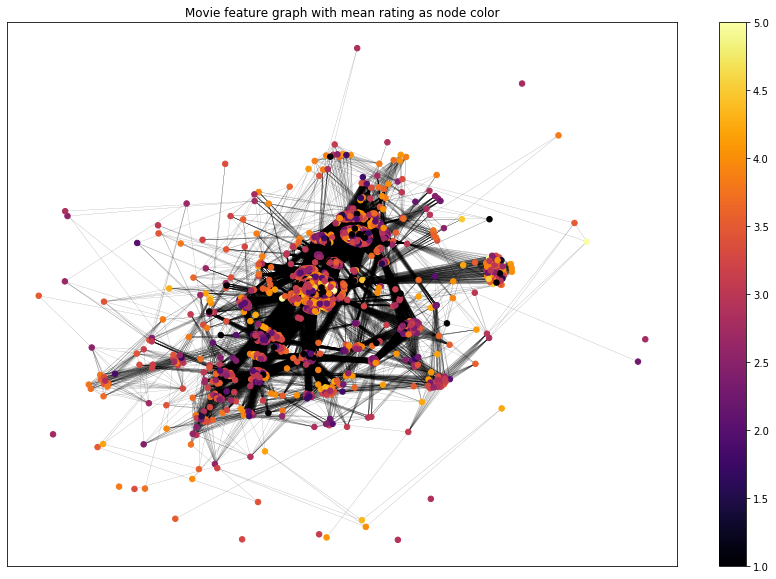

In [71]:
G_movie = nx.from_numpy_matrix(adjacency_movies)
coords = nx.spring_layout(G_movie, 0.2)  
fig = plt.figure(figsize=(15, 10))
labels = movies['mean_rating'].iloc[np.sort(nx.nodes(G_movie))]
im = nx.draw_networkx_nodes(G_movie, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(movies['mean_rating']), vmax=max(movies['mean_rating']))
nx.draw_networkx_edges(G_movie, coords, alpha=1.0, width=0.1)
plt.title('Movie feature graph with mean rating as node color', size='large')
plt.colorbar(im);

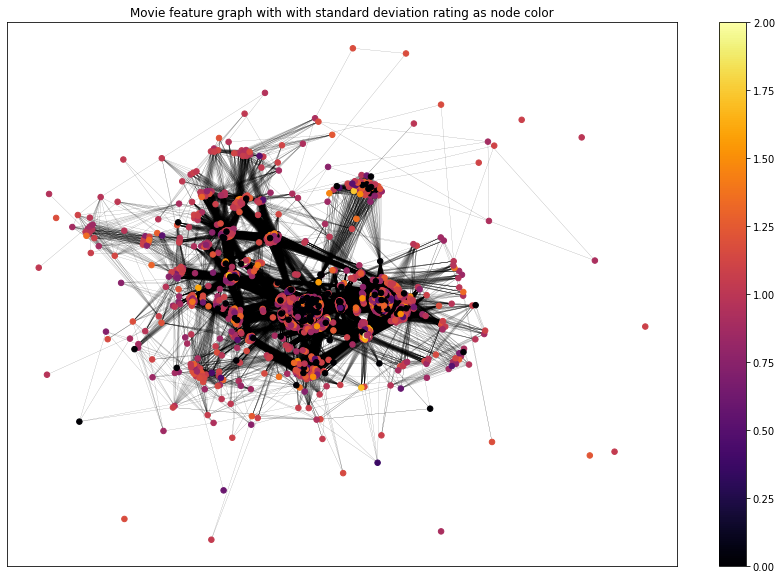

In [72]:
coords = nx.spring_layout(G_movie, 0.2)  
fig = plt.figure(figsize=(15, 10))
labels = movies['std_rating'].iloc[np.sort(nx.nodes(G_movie))]
im = nx.draw_networkx_nodes(G_movie, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(movies['std_rating']), vmax=max(movies['std_rating']))
nx.draw_networkx_edges(G_movie, coords, alpha=1.0, width=0.1)
plt.title('Movie feature graph with with standard deviation rating as node color', size='large')
plt.colorbar(im);

In [74]:
degrees_movies = np.sum(adjacency_movies, axis = 0)
print('Number of nodes in the feature graph: {}, Number of edges in the feature features: {}'. \
      format(G_movie.number_of_nodes(), G_movie.number_of_edges()))
print('Average degree of the feature graph: {:.4f}, Standard deviation of the degree in the feature graph: {:.4f}'. \
      format(np.mean(degrees_movies), np.std(degrees_movies)))
print('Number of connected components in the feature graph: {}, Average clustering coefficient: {}'.\
      format(nx.number_connected_components(G_movie), nx.average_clustering(G_movie)))

Number of nodes in the feature graph: 1682, Number of edges in the feature features: 263577
Average degree of the feature graph: 313.4090, Standard deviation of the degree in the feature graph: 237.4617
Number of connected components in the feature graph: 9, Average clustering coefficient: 0.7268408032132948


## Embedding Graph without features

In [75]:
embedding_users_no_features, embedding_movies_no_features, \
train_loss_values, train_rmse_values, val_loss_values, val_rmse_values = run(None, None, \
      learning_rate=0.01, epochs=1000, hidden=[500, 75], feat_hidden=10, accumulation='stack', dropout=0.7, \
      num_basis_functions=2, features=False, symmetric=False, verbose=False, testing=True)

Using official MovieLens dataset split u1.base/u1.test with 20% validation set size...


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training...
test loss =  1.222924
test rmse =  0.91128623
INFO:tensorflow:Restoring parameters from tmp/recommendergae.ckpt-1000
polyak test loss =  1.2182491
polyak test rmse =  0.90969783
global seed =  1578686768


In [76]:
distances_no_features = scipy.spatial.distance.pdist(embedding_users_no_features, metric='euclidean')
mean_distances_no_features = np.mean(distances_no_features)
print('The mean euclidean distance between each user in the no feature embedding space is {:.4f}'.\
      format(mean_distances_no_features))

The mean euclidean distance between each user in the no feature embedding space is 2.6131


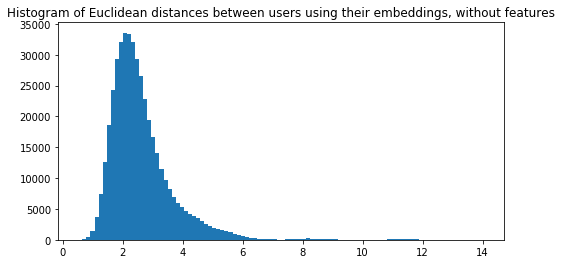

In [77]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between users using their embeddings, without features")
plt.hist(distances_no_features.flatten(), bins=100);

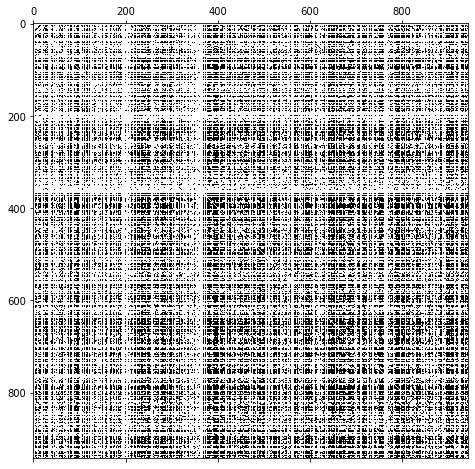

In [78]:
adjacency_no_features = epsilon_similarity_graph(embedding_users_no_features, \
                                                 sigma=0.4*mean_distances_no_features, \
                                                 epsilon=0.15)
plt.figure(figsize=(8,8))
plt.spy(adjacency_no_features)
plt.show()

In [79]:
adjacency_no_features = np.where(adjacency_no_features > 0, 1, 0)

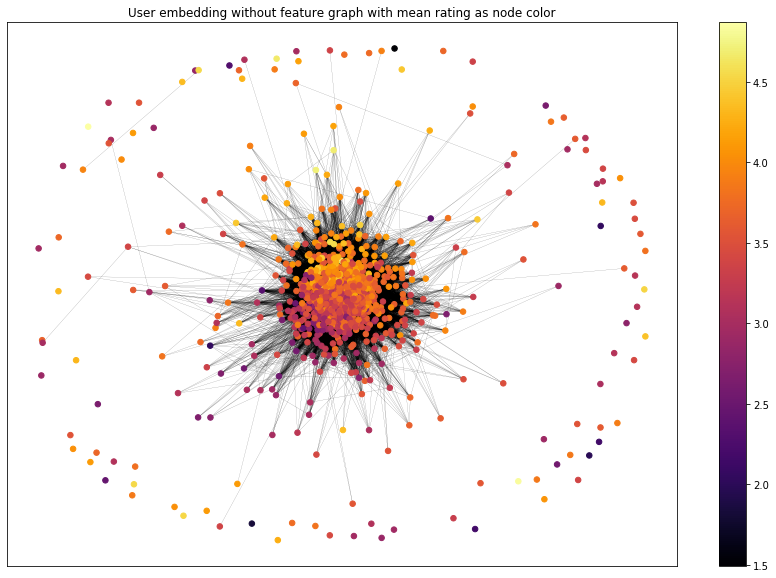

In [83]:
G_user_no_f = nx.from_numpy_matrix(adjacency_no_features)
coords = nx.spring_layout(G_user_no_f, 0.3)  
fig = plt.figure(figsize=(15, 10))
labels = users['mean_rating'].iloc[np.sort(nx.nodes(G_user_no_f))]
im = nx.draw_networkx_nodes(G_user_no_f, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(users['mean_rating']), vmax=max(users['mean_rating']))
nx.draw_networkx_edges(G_user_no_f, coords, alpha=1.0, width=0.1)
plt.title('User embedding without feature graph with mean rating as node color', size='large')
plt.colorbar(im);

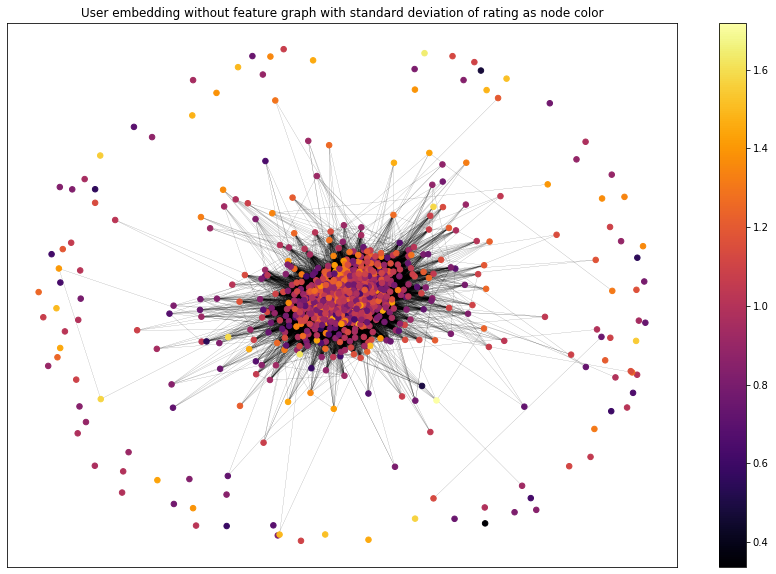

In [84]:
coords = nx.spring_layout(G_user_no_f, 0.3) 
fig = plt.figure(figsize=(15, 10))
labels = users['std_rating'].iloc[np.sort(nx.nodes(G_user_no_f))]
im = nx.draw_networkx_nodes(G_user_no_f, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(users['std_rating']), vmax=max(users['std_rating']))
nx.draw_networkx_edges(G_user_no_f, coords, alpha=1.0, width=0.1)
plt.title('User embedding without feature graph with standard deviation of rating as node color', size='large')
plt.colorbar(im);

In [86]:
degrees_no_features = np.sum(adjacency_no_features, axis = 0)
print('Number of nodes in the feature graph: {}, Number of edges in the feature features: {}'. \
      format(G_user_no_f.number_of_nodes(), G_user_no_f.number_of_edges()))
print('Average degree of the feature graph: {:.4f}, Standard deviation of the degree in the feature graph: {:.4f}'. \
      format(np.mean(degrees_no_features), np.std(degrees_no_features)))
print('Number of connected components in the feature graph: {}, Average clustering coefficient: {}'.\
      format(nx.number_connected_components(G_user_no_f), nx.average_clustering(G_user_no_f)))

Number of nodes in the feature graph: 943, Number of edges in the feature features: 136929
Average degree of the feature graph: 290.4115, Standard deviation of the degree in the feature graph: 214.1997
Number of connected components in the feature graph: 93, Average clustering coefficient: 0.7100411340042592


### Embedding Graph with features

In [87]:
u_features = sp.sparse.csr_matrix(np.asarray(users_features))
movies_features = np.asarray(movies_features).astype(float)
v_features = sp.sparse.csr_matrix(np.asarray(movies_features))

In [88]:
embedding_users, embedding_movies, \
train_loss_values, train_rmse_values, val_loss_values, val_rmse_values = run(u_features, v_features, \
      learning_rate=0.01, epochs=1500, hidden=[500, 75], feat_hidden=35, accumulation='stack', dropout=0.7, \
      num_basis_functions=2, features=True, symmetric=False, verbose=False, testing=True)

Using official MovieLens dataset split u1.base/u1.test with 20% validation set size...
Normalizing feature vectors...


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training...
test loss =  1.2223555
test rmse =  0.9018117
INFO:tensorflow:Restoring parameters from tmp/recommendersideinfogae.ckpt-1500
polyak test loss =  1.2169526
polyak test rmse =  0.89998394
global seed =  1578687500


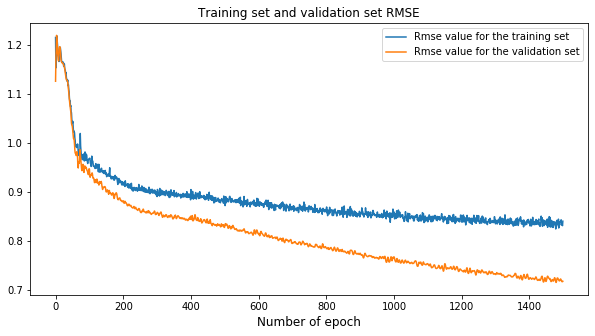

In [89]:
plt.figure(1, figsize=(10, 5))
plt.plot(train_rmse_values, label='Rmse value for the training set')
plt.plot(val_rmse_values, label='Rmse value for the validation set')
plt.xlabel('Number of epoch', size='large')
plt.title('Training set and validation set RMSE')
plt.legend();

In [90]:
distances = scipy.spatial.distance.pdist(embedding_users, metric='euclidean')
mean_distances = np.mean(distances)
print('The mean euclidean distance between each user in embedding space with features is {:.4f}'.\
      format(mean_distances))

The mean euclidean distance between each user in embedding space with features is 4.7628


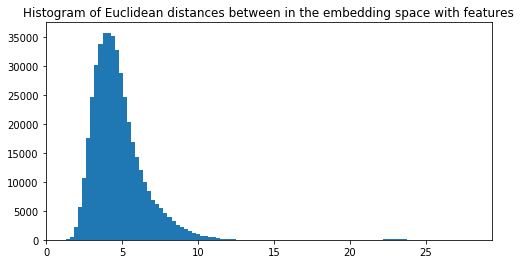

In [91]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between in the embedding space with features")
plt.hist(distances.flatten(), bins=100);

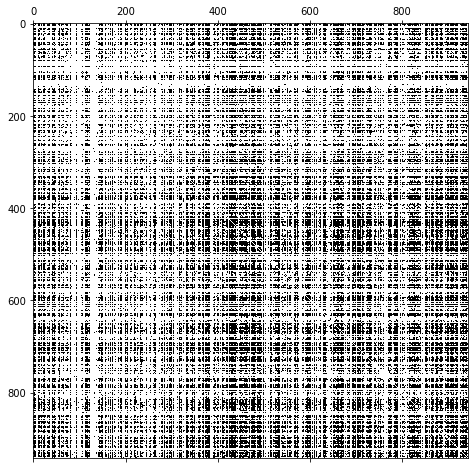

In [92]:
adjacency = epsilon_similarity_graph(embedding_users, sigma=0.4*mean_distances, epsilon=0.15)
plt.figure(figsize=(8,8))
plt.spy(adjacency)
plt.show()

In [93]:
adjacency = np.where(adjacency > 0, 1, 0)

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


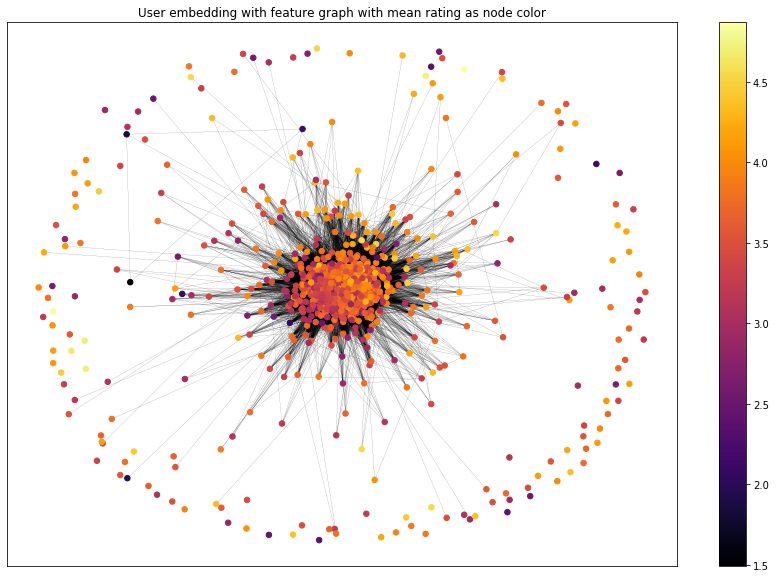

In [94]:
G = nx.from_numpy_matrix(adjacency)
coords = nx.spring_layout(G, 0.3)  
fig = plt.figure(figsize=(15, 10))
labels = users['mean_rating'].iloc[np.sort(nx.nodes(G))]
im = nx.draw_networkx_nodes(G, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(users['mean_rating']), vmax=max(users['mean_rating']))
nx.draw_networkx_edges(G, coords, alpha=1.0, width=0.1)
plt.title('User embedding with feature graph with mean rating as node color', size='large')
plt.colorbar(im);

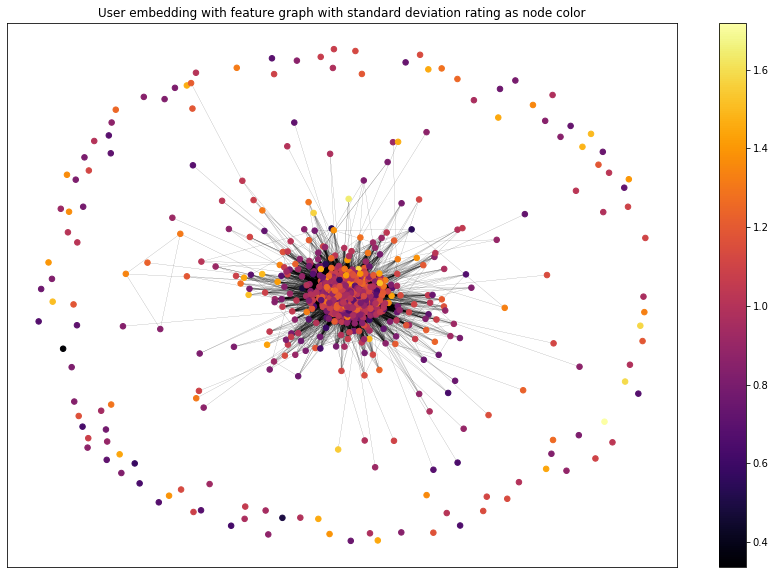

In [95]:
coords = nx.spring_layout(G, 0.2)  
fig = plt.figure(figsize=(15, 10))
labels = users['std_rating'].iloc[np.sort(nx.nodes(G))]
im = nx.draw_networkx_nodes(G, coords, node_size=30, node_color=labels, cmap='inferno',\
                            vmin=min(users['std_rating']), vmax=max(users['std_rating']))
nx.draw_networkx_edges(G, coords, alpha=1.0, width=0.1)
plt.title('User embedding with feature graph with standard deviation rating as node color', size='large')
plt.colorbar(im);

In [96]:
degrees = np.sum(adjacency, axis = 0)
print('Number of nodes in the feature graph: {}, Number of edges in the feature graph: {}'. \
      format(G.number_of_nodes(), G.number_of_edges()))
print('Average degree of the feature graph: {:.4f}, Standard deviation of the degree in the feature graph: {:.4f}'. \
      format(np.mean(degrees), np.std(degrees)))
print('Number of connected components in the feature graph: {}, Average clustering coefficient: {}'.\
      format(nx.number_connected_components(G), nx.average_clustering(G)))

Number of nodes in the feature graph: 943, Number of edges in the feature graph: 125491
Average degree of the feature graph: 266.1527, Standard deviation of the degree in the feature graph: 217.8771
Number of connected components in the feature graph: 120, Average clustering coefficient: 0.7049042016244215
